<img src="http://xarray.pydata.org/en/stable/_static/dataset-diagram-logo.png" align="right" width="30%">

# Basic Computation

In this lesson, we discuss how to do scientific computations with xarray
objects. Our learning goals are as follows. By the end of the lesson, we will be
able to:

- Apply basic arithmetic and numpy functions to xarray DataArrays / Dataset.
- Use Xarray's label-aware reduction operations (e.g. `mean`, `sum`) weighted
  reductions.
- Apply arbitrary functions to Xarray data via `apply_ufunc`.
- Use Xarray's broadcasting to compute on arrays of different dimensionality.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Ask Xarray to not show data values by default
xr.set_options(display_expand_data=False)

%config InlineBackend.figure_format='retina'

## Example Dataset

First we load a dataset. We will use the
[NOAA Extended Reconstructed Sea Surface Temperature (ERSST) v5](https://www.ncdc.noaa.gov/data-access/marineocean-data/extended-reconstructed-sea-surface-temperature-ersst-v5)
product, a widely used and trusted gridded compilation of of historical data going back to 1854.

In [2]:
ds = xr.tutorial.load_dataset("ersstv5")
ds

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 624, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    sst        (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2022-06-07

Let's do some basic visualizations of the data, just to make sure it looks
reasonable.


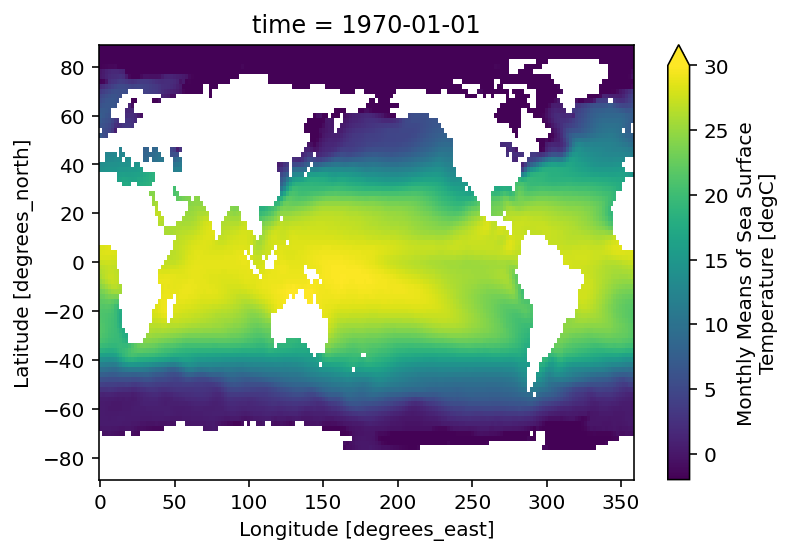

In [3]:
ds.sst.isel(time=0).plot(vmin=-2, vmax=30);

## Arithmetic

Xarray dataarrays and datasets work seamlessly with arithmetic operators and
numpy array functions.

For example, imagine we want to convert the temperature (given in Celsius) to
Kelvin:


In [4]:
sst_kelvin = ds.sst + 273.15
sst_kelvin

<xarray.DataArray 'sst' (time: 624, lat: 89, lon: 180)>
271.4 271.4 271.4 271.4 271.4 271.4 271.4 271.4 ... nan nan nan nan nan nan nan
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-12-01

The dimensions and coordinates were preserved following the operation.

<div class="alert alert-warning">
    <strong>Warning:</strong> Although many xarray datasets have a <code>units</code> attribute, which is used in plotting,
    Xarray does not inherently understand units. However, xarray can integrate with <a href="https://pint.readthedocs.io/en/0.12/">pint</a>, which provides full unit-aware operations. See <a href="https://pint-xarray.readthedocs.io">pint-xarray</a> for more.
</div>


## Applying functions

We can apply more complex functions to Xarray objects.
Imagine we wanted to compute the following expression as a function of SST
($\Theta$) in Kelvin:

$$ f(\Theta) =  0.5 \ln(\Theta^2) $$


In [5]:
f = 0.5 * np.log(sst_kelvin**2)
f

<xarray.DataArray 'sst' (time: 624, lat: 89, lon: 180)>
5.603 5.603 5.603 5.603 5.603 5.603 5.603 5.603 ... nan nan nan nan nan nan nan
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-12-01

## Applying Arbitrary Functions

It's awesome that we can call `np.log(ds)` and have it "just work". However, not
all third party libraries work this way.

numpy's [nan_to_num](https://numpy.org/devdocs/reference/generated/numpy.nan_to_num.html) for example will return a numpy array

In [6]:
np.nan_to_num(ds.sst, 0)

array([[[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        ...,
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]],

       [[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        ...,
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]],

       [[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        ...,
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]],

       ...,

       [[-1.8, -1.8, -1.

It would be nice to keep our dimensions and coordinates. 

We can accomplish this with [xr.apply_ufunc](https://docs.xarray.dev/en/stable/generated/xarray.apply_ufunc.html#xarray.apply_ufunc)

In [7]:
xr.apply_ufunc(np.nan_to_num, ds.sst, 0)

<xarray.DataArray 'sst' (time: 624, lat: 89, lon: 180)>
-1.8 -1.8 -1.8 -1.8 -1.8 -1.8 -1.8 -1.8 -1.8 ... 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-12-01

<div class="alert alert-info">
    <strong>Note:</strong> <code>apply_ufunc</code> is a powerful function.
    It has many options for doing more complicated things.
    Unfortunately, we don't have time to go into more depth here.
    Please consult the <a href="https://docs.xarray.dev/en/stable/user-guide/dask.html#apply-ufunc">documentation</a> for more details.
</div>


## Reductions

Reductions are functions that reduce the dimensionlity of our dataset. For example taking the mean sea surface temperature along `time` of our 3D data, we "reduce" the  `time` dimension and are left with a 2D array.

Just like in numpy, we can reduce xarray DataArrays along any number of axes.

In [8]:
sst = ds.sst
sst.mean(axis=0)

<xarray.DataArray 'sst' (lat: 89, lon: 180)>
-1.799 -1.799 -1.799 -1.799 -1.799 -1.8 -1.8 ... 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

However, rather than performing reductions by specifying `axis` (as in numpy), we can instead perform
them using _dimension names_. This turns out to be a huge convenience, particularly in
complex calculations it can be hard to remember which axis corresponds to 
which dimension name:

In [9]:
sst.mean(dim="time")

<xarray.DataArray 'sst' (lat: 89, lon: 180)>
-1.799 -1.799 -1.799 -1.799 -1.799 -1.8 -1.8 ... 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

You can reduce over multiple dimensions

In [10]:
sst.mean(["lat", "time"])

<xarray.DataArray 'sst' (lon: 180)>
7.692 7.824 8.239 8.131 7.586 7.546 ... 9.776 9.419 8.303 7.818 7.842 7.641
Coordinates:
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

If no dimension is specified, the reduction is applied across all dimensions.

In [11]:
sst.mean()

<xarray.DataArray 'sst' ()>
9.473

All of the standard numpy reductions (e.g. `min`, `max`, `sum`, `std`, etc.) are
available on both [Datasets](https://docs.xarray.dev/en/stable/api.html#aggregation) and [DataArrays](https://docs.xarray.dev/en/stable/api.html#id6).


### Exercise

Take the mean of `sst` in both longitude and latitude. Make a simple timeseries
plot:


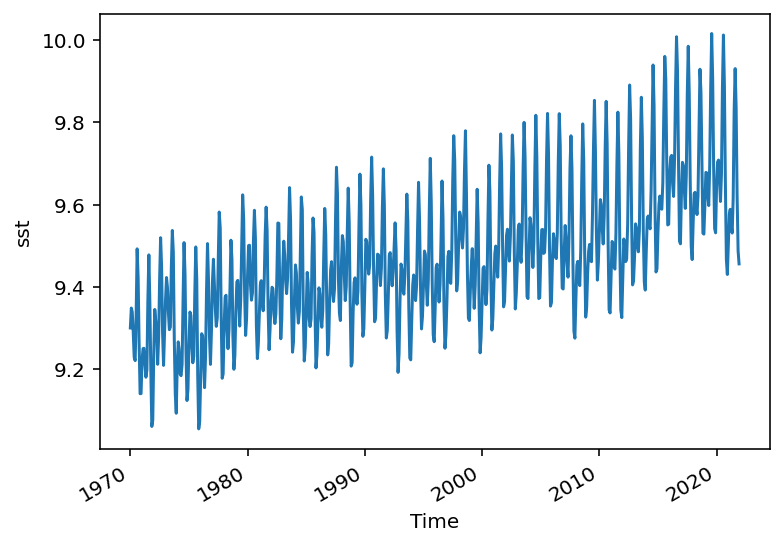

In [12]:
sst.mean(["lat", "lon"]).plot();

In [13]:
dir(sst)

['T',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__dask_graph__',
 '__dask_keys__',
 '__dask_layers__',
 '__dask_optimize__',
 '__dask_postcompute__',
 '__dask_postpersist__',
 '__dask_scheduler__',
 '__dask_tokenize__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__

In [14]:
help(sst.reduce)

Help on method reduce in module xarray.core.dataarray:

reduce(func: 'Callable[..., Any]', dim: 'None | Hashable | Sequence[Hashable]' = None, axis: 'None | int | Sequence[int]' = None, keep_attrs: 'bool' = None, keepdims: 'bool' = False, **kwargs: 'Any') -> 'DataArray' method of xarray.core.dataarray.DataArray instance
    Reduce this array by applying `func` along some dimension(s).
    
    Parameters
    ----------
    func : callable
        Function which can be called in the form
        `f(x, axis=axis, **kwargs)` to return the result of reducing an
        np.ndarray over an integer valued axis.
    dim : hashable or sequence of hashable, optional
        Dimension(s) over which to apply `func`.
    axis : int or sequence of int, optional
        Axis(es) over which to repeatedly apply `func`. Only one of the
        'dim' and 'axis' arguments can be supplied. If neither are
        supplied, then the reduction is calculated over the flattened array
        (by calling `f(x)` 

In [15]:
import numpy as np

In [17]:
dir(np.sin)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__name__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'accumulate',
 'at',
 'identity',
 'nargs',
 'nin',
 'nout',
 'ntypes',
 'outer',
 'reduce',
 'reduceat',
 'signature',
 'types']

In [18]:
help(np.sin.reduce)

Help on built-in function reduce:

reduce(...) method of numpy.ufunc instance
    reduce(array, axis=0, dtype=None, out=None, keepdims=False, initial=<no value>, where=True)
    
    Reduces `array`'s dimension by one, by applying ufunc along one axis.
    
    Let :math:`array.shape = (N_0, ..., N_i, ..., N_{M-1})`.  Then
    :math:`ufunc.reduce(array, axis=i)[k_0, ..,k_{i-1}, k_{i+1}, .., k_{M-1}]` =
    the result of iterating `j` over :math:`range(N_i)`, cumulatively applying
    ufunc to each :math:`array[k_0, ..,k_{i-1}, j, k_{i+1}, .., k_{M-1}]`.
    For a one-dimensional array, reduce produces results equivalent to:
    ::
    
     r = op.identity # op = ufunc
     for i in range(len(A)):
       r = op(r, A[i])
     return r
    
    For example, add.reduce() is equivalent to sum().
    
    Parameters
    ----------
    array : array_like
        The array to act on.
    axis : None or int or tuple of ints, optional
        Axis or axes along which a reduction is performed.
 

In [19]:
np.sin.reduce(np.array([1, 2, 3]))

ValueError: reduce only supported for binary functions

In [21]:
dir(np.sin)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__name__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'accumulate',
 'at',
 'identity',
 'nargs',
 'nin',
 'nout',
 'ntypes',
 'outer',
 'reduce',
 'reduceat',
 'signature',
 'types']

In [23]:
help(np.sin.reduceat)

Help on built-in function reduceat:

reduceat(...) method of numpy.ufunc instance
    reduceat(array, indices, axis=0, dtype=None, out=None)
    
    Performs a (local) reduce with specified slices over a single axis.
    
    For i in ``range(len(indices))``, `reduceat` computes
    ``ufunc.reduce(array[indices[i]:indices[i+1]])``, which becomes the i-th
    generalized "row" parallel to `axis` in the final result (i.e., in a
    2-D array, for example, if `axis = 0`, it becomes the i-th row, but if
    `axis = 1`, it becomes the i-th column).  There are three exceptions to this:
    
    * when ``i = len(indices) - 1`` (so for the last index),
      ``indices[i+1] = array.shape[axis]``.
    * if ``indices[i] >= indices[i + 1]``, the i-th generalized "row" is
      simply ``array[indices[i]]``.
    * if ``indices[i] >= len(array)`` or ``indices[i] < 0``, an error is raised.
    
    The shape of the output depends on the size of `indices`, and may be
    larger than `array` (this happ

In [24]:
help(np.sin.outer)

Help on built-in function outer:

outer(...) method of numpy.ufunc instance
    outer(A, B, /, **kwargs)
    
    Apply the ufunc `op` to all pairs (a, b) with a in `A` and b in `B`.
    
    Let ``M = A.ndim``, ``N = B.ndim``. Then the result, `C`, of
    ``op.outer(A, B)`` is an array of dimension M + N such that:
    
    .. math:: C[i_0, ..., i_{M-1}, j_0, ..., j_{N-1}] =
       op(A[i_0, ..., i_{M-1}], B[j_0, ..., j_{N-1}])
    
    For `A` and `B` one-dimensional, this is equivalent to::
    
      r = empty(len(A),len(B))
      for i in range(len(A)):
          for j in range(len(B)):
              r[i,j] = op(A[i], B[j])  # op = ufunc in question
    
    Parameters
    ----------
    A : array_like
        First array
    B : array_like
        Second array
    kwargs : any
        Arguments to pass on to the ufunc. Typically `dtype` or `out`.
        See `ufunc` for a comprehensive overview of all available arguments.
    
    Returns
    -------
    r : ndarray
        Outpu

In [26]:
help(np.dot)

Help on function dot in module numpy:

dot(...)
    dot(a, b, out=None)
    
    Dot product of two arrays. Specifically,
    
    - If both `a` and `b` are 1-D arrays, it is inner product of vectors
      (without complex conjugation).
    
    - If both `a` and `b` are 2-D arrays, it is matrix multiplication,
      but using :func:`matmul` or ``a @ b`` is preferred.
    
    - If either `a` or `b` is 0-D (scalar), it is equivalent to :func:`multiply`
      and using ``numpy.multiply(a, b)`` or ``a * b`` is preferred.
    
    - If `a` is an N-D array and `b` is a 1-D array, it is a sum product over
      the last axis of `a` and `b`.
    
    - If `a` is an N-D array and `b` is an M-D array (where ``M>=2``), it is a
      sum product over the last axis of `a` and the second-to-last axis of `b`::
    
        dot(a, b)[i,j,k,m] = sum(a[i,j,:] * b[k,:,m])
    
    Parameters
    ----------
    a : array_like
        First argument.
    b : array_like
        Second argument.
    out : 